<a href="https://colab.research.google.com/github/JacopoKahl/CycleGAN/blob/main/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CycleGAN

Composed by 4 models: 2 generators and 2 discriminators

**Objective**: Train generators (together with discriminators) to be able to transgorm input images.

**Dataset**: apple2orange image dataset

**Notation**:

1.   **g_AB**: Generator for A->B image conversion
2.   **G_BA**: Generator for B->A image conversion
3.   **d_A**: Discriminator for A type images
4.   **d_B**: Discriminator for B type images



In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


##Imports


*   Need to install keras-contrib from GitHub!



In [2]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-6h_ynl_g
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-6h_ynl_g
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101066 sha256=0b2f7c28fafbe2c6ec4e56f24506ee4ba02f033b77265d24edfde3a996beb67e
  Stored in directory: /tmp/pip-ephem-wheel-cache-uc5qpke7/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [3]:
from keras.models import Model #Keras Functional API

from keras.layers import Input, Conv2D, UpSampling2D, Activation, LeakyReLU, Concatenate, BatchNormalization, Dropout

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization #InstanceNormalization layer is part of keras.contrib installed above

#from keras.initializers import RandomNormal

from keras.optimizers import Adam #import adam to specify settings

import numpy as np #import numpy numerical library

from glob import glob #glob is a function used for listing file path

from PIL import Image #Python Imaging library used here for simply opening image files and transforming input into bitmap format. Here only the Image class is imported.
#import cv2 #alternatively one can import the OpenCV library (famous for image processing)

#Visualization
import matplotlib.pyplot as plt #plot charts

from keras.utils import plot_model #visualization chart of the models

from tqdm import tqdm #progress bar

Using TensorFlow backend.


##Dataset 

https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Dataset

###Unzip and prepare working directory

In [6]:
#print working directory
%pwd

'/content'

In [7]:
#print list files
%ls

drive/  sample_data/


In [8]:
%cd '/content/drive/MyDrive/AI_for_Multimedia/Lezione12/'

/content/drive/MyDrive/AI_for_Multimedia/Lezione12


In [9]:
#print list files
%ls

apple2orange.zip


In [10]:
!unzip -q apple2orange.zip -d /content/

In [11]:
%cd /content/apple2orange/

/content/apple2orange


In [12]:
%ls

testA/  testB/  trainA/  trainB/


In [14]:
#Create image file lists

trainA_files = glob('trainA/*.jpg')
trainB_files = glob('trainB/*.jpg')

testA_files = glob('testA/*.jpg')
testB_files = glob('testB/*.jpg')

##Explore dataset

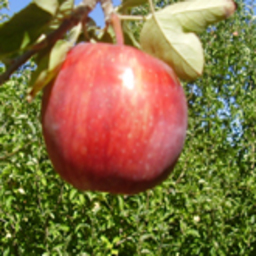

In [15]:
index = 0
img = Image.open(trainA_files[index])

img

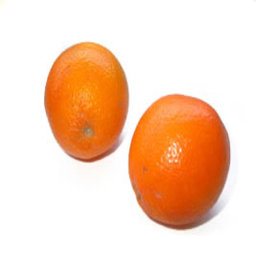

In [16]:
img = Image.open(trainB_files[index])

img

In [17]:
#Function to convert images into elments of a numpy array
#The function returns a numpy array of bitmaps

def files2array (filelist, image_wh=(128,128)):
  return np.array([np.array(Image.open(fname).resize(image_wh)) for fname in filelist])


In [18]:
#This cell generates the train and test arrays by calliung the files2array function defined above

image_dim = (128,128) #resolution after resize

X_trainA = files2array(trainA_files, image_dim) / 127.5 - 1.
X_trainB = files2array(trainB_files, image_dim) / 127.5 - 1.

X_testA = files2array(testA_files, image_dim) / 127.5 - 1.
X_testB = files2array(testB_files, image_dim) / 127.5 - 1.

In [19]:
print('X_trainA shape: ', X_trainA.shape)
print('X_trainB shape: ', X_trainB.shape)

print('X_testA shape: ', X_testA.shape)
print('X_testB shape: ', X_testB.shape)

X_trainA shape:  (995, 128, 128, 3)
X_trainB shape:  (1019, 128, 128, 3)
X_testA shape:  (266, 128, 128, 3)
X_testB shape:  (248, 128, 128, 3)


##Settings

In [20]:
input_dim = X_trainA.shape[1:]
learning_rate = 0.0002

#Weights for loss functions
lambda_validation = 1
lambda_reconstr = 10
lambda_id = 2

genrator_type = 'u-net'

#Filters number (will be multiplied in the model) from generator and discriminator
gen_n_filters = 32
disc_n_filters = 32

epochs = 10

##Generators

In [21]:
def build_generator_unet(img_shape, model_name):

  #Function for building one downsampling block
  def downsample(layer_input, filters, f_size=4):
    d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
    d = InstanceNormalization(axis = -1, center=False, scale=False)(d)
    d = Activation('relu')(d)
    return d

  #Function for building one upsampling block
  def upsample(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
    u = UpSampling2D(size=2)(layer_input)
    u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same')(u)
    u = InstanceNormalization(axis = -1, center=False, scale=False)(u)
    u = Activation('relu')(u)

    if dropout_rate:
      u = Dropout(dropout_rate)(u) #optional dropout layer
    u = Concatenate()([u, skip_input]) #concatenate (processed) output from previous upsampling block with skip connection input
    return u

  #Instructions of the build_generator_unet function ---------------------
  
  img = Input(shape=img_shape) #Input layer

  #Downsampling blocks
  d1 = downsample(img, gen_n_filters) #1st downsampling block
  d2 = downsample(d1, gen_n_filters * 2) #2nd downsampling block
  d3 = downsample(d2, gen_n_filters * 4) #3rd downsampling block
  d4 = downsample(d3, gen_n_filters * 8) #4th downsampling block

  #Upsampling blocks (note double input to the function: from previous block and skip connection)
  u1 = upsample(d4, d3, gen_n_filters * 4) #1st upsampling block
  u2 = upsample(u1, d2, gen_n_filters * 2) #2nd upsampling block
  u3 = upsample(u2, d1, gen_n_filters * 2) #3rd upsampling block
  u4 = UpSampling2D(size=2)(u3)            #4th upsampling block
  output = Conv2D(filters=img_shape[2], kernel_size=4, strides=1, padding='same', activation='tanh') (u4)

  return Model(img, output, name=model_name)
  

##Discriminators

In [22]:
def build_discriminator(img_shape, model_name):

  #Function for building a convolutional block
  def conv4(layer_input, filters, stride=2, norm=True):
    y = Conv2D(filters, kernel_size=4, strides=stride, padding='same') (layer_input)
    if norm:
      y = InstanceNormalization(axis = -1, center=False, scale=False)(y)
      y = LeakyReLU(0.2)(y)
    return y

  #build_discriminator function instructions -----------------------------
  img = Input(shape=img_shape)
  y = conv4(img, disc_n_filters, stride=2, norm=False)
  y = conv4(y, disc_n_filters*2, stride=2)
  y = conv4(y, disc_n_filters*4, stride=2)
  y = conv4(y, disc_n_filters*8, stride=2)

  output = Conv2D(1, kernel_size=4, strides=1, padding='same')(y)

  return Model(img, output, name=model_name)

##Compiling the CycleGAN

###Create discriminators

In [23]:
d_A = build_discriminator(input_dim, 'd_A')
d_B = build_discriminator(input_dim, 'd_B')

d_A.compile(loss='mse', optimizer=Adam(learning_rate, 0.5), metrics=['accuracy'])
d_B.compile(loss='mse', optimizer=Adam(learning_rate, 0.5), metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


##Create the generators

In [24]:
#Create generators
g_AB = build_generator_unet(input_dim, 'g_AB')
g_BA = build_generator_unet(input_dim, 'g_BA')

d_A.trainable = False
d_B.trainable = False

#Input images from both domains
img_A = Input(shape=input_dim, name='img_A')
img_B = Input(shape=input_dim, name='img_B')

#Transform images to the other domain
fake_A = g_BA(img_B)
fake_B = g_AB(img_A)

#Validity: discriminators checks validity of transformed images
valid_A = d_A(fake_A)
valid_B = d_B(fake_B)

#Reconstruction: Translate omages back to original domain
reconstr_A = g_BA(fake_B)
reconstr_B = g_AB(fake_A)

#Identity: identity mapping images
img_A_id = g_BA(img_A)
img_B_id = g_AB(img_B)

In [25]:
#Define cycleGAN: please note the 6 outputs as defined above
cycleGAN = Model(inputs=[img_A, img_B], outputs=[valid_A, valid_B, reconstr_A, reconstr_B, img_A_id, img_B_id], name='CycleGAN')

opt = Adam(lr=0.0002, beta_1=0.5)

cycleGAN.compile(loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'],
                 loss_weights=[lambda_validation, lambda_validation, lambda_reconstr, lambda_reconstr, lambda_id, lambda_id],
                 optimizer=opt)

cycleGAN.summary() #note the 8x8x1 output of the GAN in the summary

Model: "CycleGAN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_B (InputLayer)              (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
img_A (InputLayer)              (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
g_BA (Model)                    (None, 128, 128, 3)  1612515     img_B[0][0]                      
                                                                 g_AB[1][0]                       
                                                                 img_A[0][0]                      
___________________________________________________________________________________________

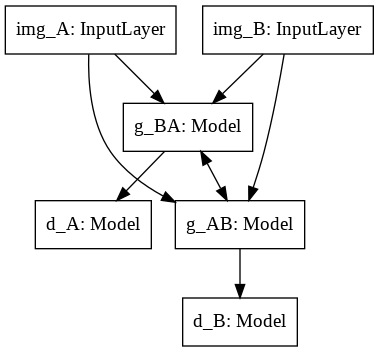

In [26]:
plot_model(cycleGAN, to_file='cycleGAN.png')

##Training

In [27]:
print(X_trainA.shape)
print(X_trainB.shape)

(995, 128, 128, 3)
(1019, 128, 128, 3)


In [31]:
batch_size = 1 #note one single sample for each batch

img_rows = input_dim[0]

patch = int(img_rows / 2**4)

disc_patch = (patch, patch, 1)
valid = np.ones((batch_size,) + disc_patch)
fake = np.zeros((batch_size,) + disc_patch)

#Function for sampling batches
def getBatch(A_set, B_set, batch_size):
  n_batches = int(min(len(A_set), len(B_set)) / batch_size)
  total_samples = n_batches * batch_size

  batch_A = np.random.choice(total_samples, batch_size, replace=False)
  batch_B = np.random.choice(total_samples, batch_size, replace=False)

  return A_set[batch_A], B_set[batch_B]

n_batches = int(min(len(X_trainA), len(X_trainB)) / batch_size)

for epoch in range (epochs):
  print('Epoch: ', epoch)
  for i in tqdm(range(n_batches)):
    #Generate fakes from generators
    imgs_A, imgs_B = getBatch(X_trainA, X_trainB, batch_size)
    fake_B = g_AB.predict(imgs_A)
    fake_A = g_BA.predict(imgs_B)

    d_A.trainable = True
    d_B.trainable = True

    #Train discriminators
    dA_loss_real = d_A.train_on_batch(imgs_A, valid)
    dA_loss_fake = d_A.train_on_batch(fake_A, fake)
    dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

    dB_loss_real = d_B.train_on_batch(imgs_B, valid)
    dB_loss_fake = d_B.train_on_batch(fake_B, fake)
    dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

    #Train generators
    d_A.trainable = False
    d_B.trainable = False

    d_loss = 0.5 * np.add(dA_loss, dB_loss)
    g_loss = cycleGAN.train_on_batch([imgs_A, imgs_B], [valid, valid, imgs_A, imgs_B, imgs_A, imgs_B])
  cycleGAN.save_weights('cycleGAN_weights.h5')
  print('Epoch %d : weights saved' %epoch)



  0%|          | 0/995 [00:00<?, ?it/s]

Epoch:  0



100%|██████████| 995/995 [02:21<00:00,  7.05it/s]

  0%|          | 1/995 [00:00<02:09,  7.70it/s]

Epoch 0 : weights saved
Epoch:  1



100%|██████████| 995/995 [02:04<00:00,  7.97it/s]

  0%|          | 1/995 [00:00<02:03,  8.07it/s]

Epoch 1 : weights saved
Epoch:  2



100%|██████████| 995/995 [02:04<00:00,  8.01it/s]

  0%|          | 1/995 [00:00<02:02,  8.09it/s]

Epoch 2 : weights saved
Epoch:  3



100%|██████████| 995/995 [02:04<00:00,  7.98it/s]

  0%|          | 1/995 [00:00<02:00,  8.24it/s]

Epoch 3 : weights saved
Epoch:  4



100%|██████████| 995/995 [02:04<00:00,  8.01it/s]

  0%|          | 1/995 [00:00<02:27,  6.72it/s]

Epoch 4 : weights saved
Epoch:  5



100%|██████████| 995/995 [02:03<00:00,  8.07it/s]

  0%|          | 1/995 [00:00<02:01,  8.19it/s]

Epoch 5 : weights saved
Epoch:  6



100%|██████████| 995/995 [02:02<00:00,  8.12it/s]

  0%|          | 1/995 [00:00<02:01,  8.19it/s]

Epoch 6 : weights saved
Epoch:  7



100%|██████████| 995/995 [02:02<00:00,  8.13it/s]

  0%|          | 1/995 [00:00<01:51,  8.88it/s]

Epoch 7 : weights saved
Epoch:  8



100%|██████████| 995/995 [02:02<00:00,  8.15it/s]

  0%|          | 1/995 [00:00<01:56,  8.53it/s]

Epoch 8 : weights saved
Epoch:  9



100%|██████████| 995/995 [02:02<00:00,  8.15it/s]

Epoch 9 : weights saved


In [32]:
numSamples = 10

imgsA, imgsB = getBatch(X_testA, X_testB, numSamples)

In [33]:
fakeA = g_BA.predict(imgsB)
fakeB = g_AB.predict(imgsA)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


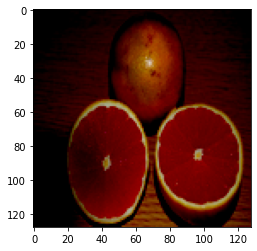

In [52]:
index = 9
plt.imshow(imgsB[index])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


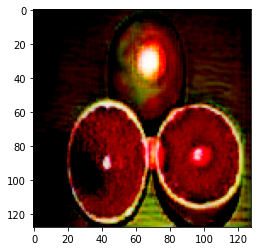

In [53]:
plt.imshow(fakeA[index])